## Convolutional Neural Networks (CNNs)

-- Prof. Dorien Herremans. Many thanks to Nelson Lui for the base text. 



### 1. Using the GPU with pytorch


Remember why we are using NN, and more specifically CNNs with GPU? Because matrix multiplications go extremely fast. 

Note that the first time you run this code there might be some delay in starting up the GPU, so it might actually be slower, so try running this cell multiple times.

In [ ]:
import torch
import time

# Let's create two matrices of size dxd and full of random values.
d = 5000
a = torch.rand(d, d)
b = torch.rand(d, d)

# Compute a multiplication between the two matrices in CPU.
start_time = time.time()
output = torch.mm(a,b)  # Regular multiplication in CPU.
cpu_time = time.time() - start_time
print('CPU-time {0:.6f}s'.format(cpu_time))

# Compute a multiplication between the two matrices in GPU.
start_time = time.time()
a = a.cuda() # Move to GPU.
b = b.cuda() # Move to GPU.
output = torch.mm(a,b)  # Multiplication happens in GPU.
gpu_time = time.time() - start_time
print('GPU-time {0:.6f}s\n'.format(gpu_time))

print('CPU was {0:.2f}x times the GPU time'.format(cpu_time / gpu_time))


CPU-time 3.350513s
GPU-time 0.034011s

CPU was 98.51x times the GPU time


Try experimenting with different values of $d$ and check what kind of improvements in the speed you can get on GPU compared to CPU.

### 2. Mini-batch SGD on FashionMNIST using pytorch nn's package.


#### 2.1 Defining a model in Pytorch


Let's start from our model from the previous lab for FashionMNIST. 

We basically recap and group the code from the previous class: We will train this two-layer neural network using pytorch's nn package. First, we will define, the model and its operations. Then we will train the model using mini-batch gradient descent. Note that we don't need to train a backward pass function anymore. Pytorch aas backward pass functions implemented for nn.Linear and F.relu AND keeps track of operations in a dynamic computation graph, so as long as you execute chains of operations supported by Pytorch your backward pass does not need to be implemented.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TwoLayerNN(nn.Module):
  def __init__(self):
    super(TwoLayerNN, self).__init__()
  
    self.linear1 = nn.Linear(1 * 28 * 28, 512)
    self.linear2 = nn.Linear(512, 10)
        
  def forward(self, x):
    x = x.view(-1, 1 * 28 * 28)
    z = F.relu(self.linear1(x))
    return self.linear2(z)    


# Using TwoLayerNN:
# Let's create a dummy batch tensor with 16 input vectors.
dummy_input = torch.zeros(16, 1 * 28 * 28)
my_model = TwoLayerNN()
dummy_output = my_model(dummy_input)

print(my_model)

print('Input size (16 input vectors):', dummy_input.shape)
print('Output size (16 output predictions):', dummy_output.shape)

TwoLayerNN(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=10, bias=True)
)
Input size (16 input vectors): torch.Size([16, 784])
Output size (16 output predictions): torch.Size([16, 10])


#### 2.2 Training a model in Pytorch

The training code is similar to the code used before but notice several simplifications and the improved generality of this code. For instance, we don't need to pass gradients ourselves layer by layer. Only one call to backward() is needed,  because this will compute gradients for all the tensors that lead up to the value of the loss.

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
import torch.optim as optim

# Removes the need to call F.to_image ourselves.
transform = transforms.Compose([transforms.ToTensor()])

# Load the training, and validation datasets.
trainset = FashionMNIST(root = './data', train = True, transform = transform, download = True)
valset = FashionMNIST(root = './data', train = False, transform = transform, download = True)

# Pytorch DataLoader for iterating over batches.
batchSize = 100

# Create the model.
model = TwoLayerNN()
loss_fn = nn.CrossEntropyLoss()

# Define a learning rate. 
learningRate = 5e-2

# Optimizer.
optimizer = optim.SGD(model.parameters(), lr = learningRate, 
                      momentum = 0.9, weight_decay = 1e-4)

def train_model(model, loss_fn, batchSize, trainset, valset, optimizer, num_epochs):
  
  # Shuffling is needed in case dataset is not shuffled by default.
  train_loader = torch.utils.data.DataLoader(dataset = trainset,
                                              batch_size = batchSize,
                                              shuffle = True)
  # We don't need to bach the validation set but let's do it anyway.
  val_loader = torch.utils.data.DataLoader(dataset = valset,
                                            batch_size = batchSize,
                                            shuffle = False) # No need.
  
  # Define number of epochs.
  N = num_epochs

  # log accuracies and losses.
  train_accuracies = []; val_accuracies = []
  train_losses = []; val_losses = []

  # GPU enabling.
  model = model.cuda()
  loss_fn = loss_fn.cuda()


  # Training loop. Please make sure you understand every single line of code below.
  # Go back to some of the previous steps in this lab if necessary.
  for epoch in range(0, N):
      correct = 0.0
      cum_loss = 0.0

      # Make a pass over the training data.
      model.train()
      for (i, (inputs, labels)) in enumerate(train_loader):
          inputs = inputs.cuda()
          labels = labels.cuda()

          # Forward pass. (Prediction stage)
          scores = model(inputs)
          loss = loss_fn(scores, labels)

          # Count how many correct in this batch.
          # https://discuss.pytorch.org/t/what-is-the-meaning-of-max-of-a-variable/14745/2
          max_scores, max_labels = scores.max(1)
          correct += (max_labels == labels).sum().item()
          cum_loss += loss.item()

          # Zero the gradients in the network.
          optimizer.zero_grad()

          #Backward pass. (Gradient computation stage)
          loss.backward()

          # Parameter updates (SGD step) -- if done with torch.optim!
          optimizer.step()

          # Parameter updates (SGD step) -- if done manually!
          # for param in model.parameters():
          #   param.data.add_(-learningRate, param.grad)

          # Logging the current results on training.
          if (i + 1) % 100 == 0:
              print('Train-epoch %d. Iteration %05d / %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                    (epoch, i + 1, len(train_loader), cum_loss / (i + 1), correct / ((i + 1) * batchSize)))

      train_accuracies.append(correct / len(trainset))
      train_losses.append(cum_loss / (i + 1))   

      # Make a pass over the validation data.
      correct = 0.0
      cum_loss = 0.0
      model.eval()
      for (i, (inputs, labels)) in enumerate(val_loader):
          inputs = inputs.cuda()
          labels = labels.cuda()

          # Forward pass. (Prediction stage)
          scores = model(inputs)
          cum_loss += loss_fn(scores, labels).item()

           # Count how many correct in this batch.
          max_scores, max_labels = scores.max(1)
          correct += (max_labels == labels).sum().item()

      val_accuracies.append(correct / len(valset))
      val_losses.append(cum_loss / (i + 1))

      # Logging the current results on validation.
      print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
            (epoch, cum_loss / (i + 1), correct / len(valset)))
      
      
train_model(model, loss_fn, batchSize, trainset, valset, optimizer, 5)

Train-epoch 0. Iteration 00100 / 00600, Avg-Loss: 0.8779, Accuracy: 0.6913
Train-epoch 0. Iteration 00200 / 00600, Avg-Loss: 0.7093, Accuracy: 0.7491
Train-epoch 0. Iteration 00300 / 00600, Avg-Loss: 0.6384, Accuracy: 0.7740
Train-epoch 0. Iteration 00400 / 00600, Avg-Loss: 0.5952, Accuracy: 0.7883
Train-epoch 0. Iteration 00500 / 00600, Avg-Loss: 0.5639, Accuracy: 0.7990
Train-epoch 0. Iteration 00600 / 00600, Avg-Loss: 0.5397, Accuracy: 0.8066
Validation-epoch 0. Avg-Loss: 0.4450, Accuracy: 0.8386
Train-epoch 1. Iteration 00100 / 00600, Avg-Loss: 0.3997, Accuracy: 0.8545
Train-epoch 1. Iteration 00200 / 00600, Avg-Loss: 0.4046, Accuracy: 0.8546
Train-epoch 1. Iteration 00300 / 00600, Avg-Loss: 0.4073, Accuracy: 0.8524
Train-epoch 1. Iteration 00400 / 00600, Avg-Loss: 0.4031, Accuracy: 0.8538
Train-epoch 1. Iteration 00500 / 00600, Avg-Loss: 0.3981, Accuracy: 0.8551
Train-epoch 1. Iteration 00600 / 00600, Avg-Loss: 0.3954, Accuracy: 0.8559
Validation-epoch 1. Avg-Loss: 0.4359, Accurac

We achieved an accuracy of 86% and achieved 84% in only one epoch. Our model is very similar to the models we implemented before, but now we are using SGD with regularization (weightDecay), and momentum updates (using the history of previous gradients) in order to update the parameters. We also have generic train_model function that is independent of the model passed as a parameter. We no longer need to focus on this training loop, and instead can concentrate in the design of model architectures. 

### 3. Convolutional Neural Network -- LeNet


Now let's implement our first convolutional neural network using Pytorch's nn.Conv2d. It is essential that you understand to a high level of detail what Conv2d does, given a certain the shape of a given input tensor, what will be the shape of the output tensor? what is the size of the weight and bias parameters? You should know answers to these questions from the lecture. Do not continue until you're sure.

In [ ]:
# Insipired on LeNet, first proposed in: 
# https://ieeexplore.ieee.org/abstract/document/726791
# PDF: http://www.cs.virginia.edu/~vicente/deeplearning/readings/lecun1998.pdf
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        # Convolutional layers.
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        
        # Linear layers.
        self.fc1 = nn.Linear(64*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Conv1 + ReLU + MaxPooling.
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        
        # Conv2 + ReLU + MaPooling.
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        
        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1) 
        
        # Linear layer + ReLU.
        out = F.relu(self.fc1(out))
        # Linear layer + ReLU.
        out = F.relu(self.fc2(out))
        # A final linear layer at the end.
        out = self.fc3(out)
       
        # We will not add Softmax here because nn.CrossEntropy does it.
        # Read the documentation for nn.CrossEntropy.
        return out

cnn_model = LeNet()

# print(cnn_model) # It shows the network structure.

# see: ADAM: A Method for Stochastic Optimization.
# This is a variant of SGD that makes adaptive step updates.
# https://arxiv.org/pdf/1412.6980.pdf
optimizer = optim.Adam(cnn_model.parameters(), lr = 3e-3)

train_model(cnn_model, loss_fn, batchSize, trainset, valset, optimizer, 5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train-epoch 0. Iteration 00100 / 00600, Avg-Loss: 0.9269, Accuracy: 0.6474
Train-epoch 0. Iteration 00200 / 00600, Avg-Loss: 0.7490, Accuracy: 0.7137
Train-epoch 0. Iteration 00300 / 00600, Avg-Loss: 0.6574, Accuracy: 0.7492
Train-epoch 0. Iteration 00400 / 00600, Avg-Loss: 0.5995, Accuracy: 0.7724
Train-epoch 0. Iteration 00500 / 00600, Avg-Loss: 0.5599, Accuracy: 0.7893
Train-epoch 0. Iteration 00600 / 00600, Avg-Loss: 0.5269, Accuracy: 0.8022
Validation-epoch 0. Avg-Loss: 0.3729, Accuracy: 0.8613
Train-epoch 1. Iteration 00100 / 00600, Avg-Loss: 0.3404, Accuracy: 0.8724
Train-epoch 1. Iteration 00200 / 00600, Avg-Loss: 0.3390, Accuracy: 0.8751
Train-epoch 1. Iteration 00300 / 00600, Avg-Loss: 0.3375, Accuracy: 0.8759
Train-epoch 1. Iteration 00400 / 00600, Avg-Loss: 0.3339, Accuracy: 0.8780
Train-epoch 1. Iteration 00500 / 00600, Avg-Loss: 0.3315, Accuracy: 0.8789
Train-epoch 1. Iteration 00600 / 00600, Avg-Loss: 0.3258, Accuracy: 0.8810
Validation-epoch 1. Avg-Loss: 0.3350, Accurac

Now we have a working model that classifies images at ~90% accuracy. Moreover, this simple convolutional neural network often matches the accuracy of the shallow linear classifier on the very first epoch.

You can find a list of results that people have obtained on FashionMNIST using more sophisticated neural networks here, including some accuracies slightly above 95%: https://github.com/zalandoresearch/fashion-mnist

### 4. Using a Pre-Trained Convolutional Neural Network -- Resnet-50



In this section we will load a network pretrained on the ImageNet ILSVRC dataset, which has RGB images annotated with one label out of a vocabulary 1000 categories, and use it to make predictions on new images. We will use the Resnet-50 neural network proposed by a team at Microsoft Research around 2015-2016.

In [ ]:
import torchvision.models as models

# Download list of 1000 categories for the ILSVRC task in right order.
!wget -nc -q http://www.cs.virginia.edu/~vicente/vision/2019/imagenet_class_index.json
  
# Load the pre-trained model from the torchvision package.

# https://arxiv.org/abs/1512.00567  # Re-thinking the Inception Architecture.
#cnn_model = models.inception_v3(pretrained = True)

# https://arxiv.org/abs/1512.03385 # Residual Networks.
cnn_model = models.resnet50(pretrained = True)

cnn_model.eval();  # Set in evaluation mode! In this case it matters.

# print(resnet) # It shows the network structure.
# You should instead look at source code here:
# https://pytorch.org/docs/stable/_modules/torchvision/models/inception.html#inception_v3

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


Now we will use the model, but we have to be careful to use the exact same pre-processing steps for the input as it was done during training. I am providing the code here below that pre-processes images in the same way as this model was trained.

To know how to do this (scaling, normalization, etc.), you need to look up the documentation of the original model. I have done this already for you. 

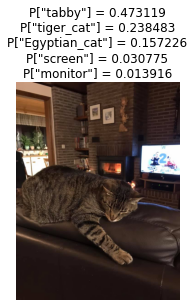

In [ ]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import json, io, requests, string

# 1. Define the appropriate image pre-processing function.
# This has to be the preprocessing function used during training. 
preprocessFn = transforms.Compose(
    [transforms.Resize(256),  # 1. Resize smallest side to 256.
     transforms.CenterCrop(224), # 2. Crop the center 224x224 pixels.
     transforms.ToTensor(), # 3. Convert to pytorch tensor.
     transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                          std = [0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
imagenetClasses = {int(idx): entry[1] for (idx, entry) in 
                   json.load(open('imagenet_class_index.json')).items()}

# 3. Read image from URL into a PIL image type.
# This is an image of my cat Sendai, currently enjoying 
# lockdown at my father's place in Belgium. 
# See more images of Sendai here: https://www.facebook.com/Sendai-251531448370007
# Or try with your own images!
img_url = 'https://dorax.s3.ap-south-1.amazonaws.com/sendai.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# 4. Forward propagate the image through the CNN.
# Unsqueeze adds a dummy batch dimension needed to pass through the model.
input_img =  preprocessFn(img_pil).unsqueeze(0)
predictions = cnn_model(input_img)

# 5. Decode the top 5 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer
# outputs and not softmax scores.
probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
probs = (-probs).numpy()[0][:5]; indices = indices.numpy()[0][:10]
preds = ['P[\"' + imagenetClasses[idx] + '\"] = ' + ('%.6f' % prob) \
         for (prob, idx) in zip(probs, indices)]

# 6. Show image and predictions
plt.title('\n'.join(preds))
plt.imshow(img_pil); plt.grid(False); plt.axis('off');

Tabby, that's correct! Notice even the screen in the background got detected. 

### 5. Fine-tuning a Pre-trained Model for a Different Task (and Dataset) 



Pre-trained models can be adapted to other tasks, by lightly re-training them (with a small learning rate), and replacing some of the last layers with custom layers for a different task. This process is usually referred as fine-tuning a network, and is the usual way of using neural networks for many applications. In this assignment we will be using the MIT Indoor Scenes Dataset introduced at CVPR 2009 http://web.mit.edu/torralba/www/indoor.html. This dataset has more than 15 thousand images belonging to 67 categories of indoor scenes (e.g. meeting room, dining room, toy store, restaurant, etc). 


#### 5.1 Downloading the Data - Indoor Place Recognition




When the MIT researchers Ariadna Quattoni and Antonio Torralba performed this work, they only used 67 \* 80 = 5360 images for training, and 67 \* 20 = 1340 images for testing, but we will use all the images instead (because our final task on which we evaluate is different). The tar file with all the images is about 2.4GB but I already downloaded, resized and cropped images to a 256x256 resolution for a total of 235MB. I also separated the images into three groups: MIT-test, which is the same test data used in the original work; and [train-uva.tar.gz](https://www.cs.virginia.edu/~vicente/deeplearning/train-uva.tar.gz), [val-uva.tar.gz](https://www.cs.virginia.edu/~vicente/deeplearning/val-uva.tar.gz) which are the rest of the images sub-divided into training and validation sets. We will not use the MIT-test images as this is the test set, so I am not providing the test images at all. The images inside these tar-files were already arranged in the format required to use the [torchvision.datasets.ImageFolder](https://pytorch.org/docs/stable/_modules/torchvision/datasets/folder.html#ImageFolder) class.

(if the download links happen to be down, use these instead: )
- https://dorax.s3.ap-south-1.amazonaws.com/MIT-indoor-val-uva.tar.gz
- https://dorax.s3.ap-south-1.amazonaws.com/MIT-indoor-train-uva.tar.gz

In [ ]:
# First download the data files.
!wget -nc https://www.cs.virginia.edu/~vicente/deeplearning/MIT-indoor-val-uva.tar.gz
!wget -nc https://www.cs.virginia.edu/~vicente/deeplearning/MIT-indoor-train-uva.tar.gz
!tar xf MIT-indoor-val-uva.tar.gz
!tar xf MIT-indoor-train-uva.tar.gz
!ls -lh

--2021-07-08 08:36:18--  https://www.cs.virginia.edu/~vicente/deeplearning/MIT-indoor-val-uva.tar.gz
Resolving www.cs.virginia.edu (www.cs.virginia.edu)... 128.143.67.11
Connecting to www.cs.virginia.edu (www.cs.virginia.edu)|128.143.67.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17513967 (17M) [application/x-gzip]
Saving to: ‘MIT-indoor-val-uva.tar.gz’

MIT-indoor-val-uva. 100%[===================>]  16.70M  7.21MB/s    in 2.3s    

2021-07-08 08:36:22 (7.21 MB/s) - ‘MIT-indoor-val-uva.tar.gz’ saved [17513967/17513967]

--2021-07-08 08:36:23--  https://www.cs.virginia.edu/~vicente/deeplearning/MIT-indoor-train-uva.tar.gz
Resolving www.cs.virginia.edu (www.cs.virginia.edu)... 128.143.67.11
Connecting to www.cs.virginia.edu (www.cs.virginia.edu)|128.143.67.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170947073 (163M) [application/x-gzip]
Saving to: ‘MIT-indoor-train-uva.tar.gz’

MIT-indoor-train-uv 100%[===================

#### 5.2 Setting up Data Loaders with Data Augmentation


We often want to apply different transformations during training compared to testing (no augmentation in the test set) to augment the data during training. In pytorch we can achieve this with minimal modifications by specifying a slightly different transformation function during training. However, one has to be careful that both training and testing images are subject to similar transformations.

Dataloaders will perform these random transformations. Run the code below multiple times and you'll see a variation on the same image. 

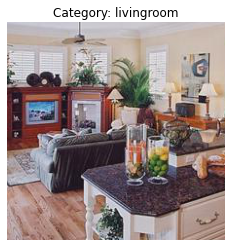

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

train_transform = transforms.Compose(
    [transforms.Resize(256),  # 1. Resize smallest side to 256.
     transforms.RandomCrop(224), # 2. Crop random square of 224x224 pixels.
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(), # 3. Convert to pytorch tensor.
     transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                          std = [0.229, 0.224, 0.225])])

test_transform = transforms.Compose(
    [transforms.Resize(256),  # 1. Resize smallest side to 256.
     transforms.CenterCrop(224), # 2. Crop center square of 224x224 pixels.
     transforms.ToTensor(), # 3. Convert to pytorch tensor.
     transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                          std = [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder("train-uva", train_transform)
val_dataset = datasets.ImageFolder("val-uva", test_transform)

# Try seeing other images in this dataset.
# If you run this cell multiple times, you will perhaps notice
# that the images are indeed slightly shifted (due to random cropping),
# or they are mirrored (due to the horizonal flipping).
# Only for the train_dataset this will happen.
my_image, my_label = train_dataset[8000]

# Show the image and its label.
plt.figure()
plt.title("Category: " + train_dataset.classes[my_label])
# Undo normalization of the pixel values.
for t, m, s in zip(my_image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
  t.mul_(s).add_(m)
# Re-arrange dimensions so it is height x width x channels.
plt.imshow(my_image.transpose(0,2).transpose(0,1));
plt.grid(False); plt.axis('off');

#### 5.3 Fine-tuning Resnet-50 for the Indoor Scene Classification task.

In this section we will take the Resnet-50 network and "fine-tune" it to the task of Indoor Scene Classification. First, we proceed to replace the last layer in resnet50 with a linear layer that outputs 67 numbers corresponding to the categories on the MIT Indoor scene recognition dataset.

In [ ]:
import torchvision.models as models
import torch.nn as nn

scene_model = models.resnet50(pretrained = True)
print(scene_model) # Print the model to see what you can modify. 
# We are modifying the last layer which is stored in the fc property
# for this model as you can see by printing out the network.
scene_model.fc = nn.Linear(2048, len(train_dataset.classes))
print(scene_model)  # Verify that the last linear layer was changed.

Now let's proceed to train this model with our dataset.

In [ ]:
import torch.optim as optim

batchSize = 50
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(scene_model.parameters(), lr = 3e-4, momentum = 0.9, weight_decay=1e-5)

train_model(scene_model, loss_fn, batchSize, train_dataset, val_dataset, optimizer, 10)

# Save your model weights after training in case you need to load them later.
# this is a very useful command btw! Often models are saved during training at multiple checkpoints
torch.save(scene_model.state_dict(), 'scene_model_weights.pth')
# If you are working on Google Cloud, make sure to download this file.

Train-epoch 0. Iteration 00100 / 00259, Avg-Loss: 3.8362, Accuracy: 0.1130
Train-epoch 0. Iteration 00200 / 00259, Avg-Loss: 3.6300, Accuracy: 0.1952
Validation-epoch 0. Avg-Loss: 3.8696, Accuracy: 0.1507
Train-epoch 1. Iteration 00100 / 00259, Avg-Loss: 2.7786, Accuracy: 0.4022
Train-epoch 1. Iteration 00200 / 00259, Avg-Loss: 2.6252, Accuracy: 0.4214
Validation-epoch 1. Avg-Loss: 3.1936, Accuracy: 0.2515
Train-epoch 2. Iteration 00100 / 00259, Avg-Loss: 2.1449, Accuracy: 0.4992
Train-epoch 2. Iteration 00200 / 00259, Avg-Loss: 2.0566, Accuracy: 0.5196
Validation-epoch 2. Avg-Loss: 2.6683, Accuracy: 0.3261
Train-epoch 3. Iteration 00100 / 00259, Avg-Loss: 1.7796, Accuracy: 0.5690
Train-epoch 3. Iteration 00200 / 00259, Avg-Loss: 1.7162, Accuracy: 0.5880
Validation-epoch 3. Avg-Loss: 2.2740, Accuracy: 0.4157
Train-epoch 4. Iteration 00100 / 00259, Avg-Loss: 1.4699, Accuracy: 0.6402
Train-epoch 4. Iteration 00200 / 00259, Avg-Loss: 1.4415, Accuracy: 0.6407
Validation-epoch 4. Avg-Loss: 

Is the model working? Accuracy looks good but let's see some predictions! Never forget to see your predictions, don't just look at numbers to assess if something is working.

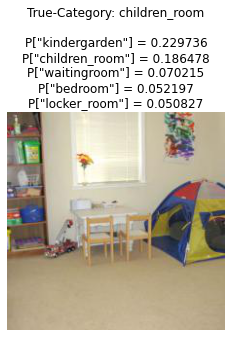

In [ ]:
# Try seeing other images in this dataset.
# If you run this cell multiple times, you will perhaps notice
# that the images are indeed slightly shifted (due to random cropping),
# or they are mirrored (due to the horizonal flipping).
# Only for the train_dataset this will happen.
my_image, my_label = val_dataset[231]

scene_model.eval()
# Load weights from file if needed.
# scene_model.load_state_dict(torch.load('scene_model_weights.pth'))
predictions = scene_model(my_image.cuda().unsqueeze(0))

preds = predictions.data.cpu().softmax(dim = 1)
probs, indices = (-preds).sort()
probs = (-probs).numpy()[0][:5]; indices = indices.numpy()[0][:5]
preds = ['P[\"' + val_dataset.classes[idx] + '\"] = ' + ('%.6f' % prob) \
         for (prob, idx) in zip(probs, indices)]

# Show the image and its label.
plt.figure()
plt.title("True-Category: " + val_dataset.classes[my_label] + "\n\n" +
          "\n".join(preds))
# Undo normalization of the pixel values.
for t, m, s in zip(my_image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
  t.mul_(s).add_(m)
# Re-arrange dimensions so it is height x width x channels.
plt.imshow(my_image.transpose(0,2).transpose(0,1));
plt.grid(False); plt.axis('off');

### 6. Using a Pretrained network as a feature extractor




Instead of finetuning, a cheaper (in term of computation) option which tends to be equally effective for small datasets is to use the pretrained network (without finetuning) to compute some output features. Typically the (latent) outputs of the network before the classification layer are used as input to another network. In this way, we only train the last layer and do not backpropagate to the previous layers. We could also precompute features for each image but this prevents us from using data augmentation.

#### 6.1 First, let's define the feature extractor

In [ ]:
import torchvision.models as models
import torch.nn as nn

# Load the pretrained ResNet model.
resnet_model = models.resnet50(pretrained = True)

# Throw away the layer that does classification on this model (the last layer).
# Then discard the height and width dimensions using tensor.view.
class FeatureExtractor(nn.Module):
  def __init__(self, resnet_model):
    super(FeatureExtractor, self).__init__()
    # remove the last layer
    self.truncated_resnet = nn.Sequential(*list(resnet_model.children())[:-1]).cuda()
  def forward(self, x):
    feats = self.truncated_resnet(x)
    return feats.view(feats.size(0), -1)

# Let's test the feature extractor to see what size are the outputs
# right before the layer we eliminated.
feature_extractor = FeatureExtractor(resnet_model)
dummy_inputs = torch.zeros(10, 3, 224, 224).cuda()
dummy_outputs = feature_extractor(dummy_inputs)
print(dummy_outputs.shape)

torch.Size([10, 2048])


#### 6.2 Now let's reimplement our train_model function to use a feature extractor. 
This requires changing our previous code in two or three places only.

In [ ]:
def train_model_2(model, 
                  feature_extractor, 
                  loss_fn, batchSize, 
                  trainset, valset, 
                  optimizer, num_epochs):
  
  # Shuffling is needed in case dataset is not shuffled by default.
  train_loader = torch.utils.data.DataLoader(dataset = trainset,
                                              batch_size = batchSize,
                                              shuffle = True)
  # We don't need to bach the validation set but let's do it anyway.
  val_loader = torch.utils.data.DataLoader(dataset = valset,
                                            batch_size = batchSize,
                                            shuffle = False) # No need.
  
  # Define number of epochs.
  N = num_epochs

  # log accuracies and losses.
  train_accuracies = []; val_accuracies = []
  train_losses = []; val_losses = []

  # GPU enabling.
  model = model.cuda()
  loss_fn = loss_fn.cuda()

  # feature extractor does not need training.
  feature_extractor.eval()

  # Training loop. Please make sure you understand every single line of code below.
  # Go back to some of the previous steps in this lab if necessary.
  for epoch in range(0, N):
      correct = 0.0
      cum_loss = 0.0

      # Make a pass over the training data.
      model.train()
      for (i, (inputs, labels)) in enumerate(train_loader):
          inputs = inputs.cuda()
          labels = labels.cuda()

          # Forward pass. (Prediction stage)
          with torch.no_grad():
            features = feature_extractor(inputs)
          scores = model(features)
          loss = loss_fn(scores, labels)

          # Count how many correct in this batch.
          max_scores, max_labels = scores.max(1)
          correct += (max_labels == labels).sum().item()
          cum_loss += loss.item()

          # Zero the gradients in the network.
          optimizer.zero_grad()

          #Backward pass. (Gradient computation stage)
          loss.backward()

          # Parameter updates (SGD step) -- if done with torch.optim!
          optimizer.step()

          # Parameter updates (SGD step) -- if done manually!
          # for param in model.parameters():
          #   param.data.add_(-learningRate, param.grad)

          # Logging the current results on training.
          if (i + 1) % 100 == 0:
              print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                    (epoch, i + 1, cum_loss / (i + 1), correct / ((i + 1) * batchSize)))

      train_accuracies.append(correct / len(trainset))
      train_losses.append(cum_loss / (i + 1))   

      # Make a pass over the validation data.
      correct = 0.0
      cum_loss = 0.0
      model.eval()
      for (i, (inputs, labels)) in enumerate(val_loader):
          inputs = inputs.cuda()
          labels = labels.cuda()

          # Forward pass. (Prediction stage)
          with torch.no_grad():
            features = feature_extractor(inputs)
            scores = model(features)
            cum_loss += loss_fn(scores, labels).item()

           # Count how many correct in this batch.
          max_scores, max_labels = scores.max(1)
          correct += (max_labels == labels).sum().item()

      val_accuracies.append(correct / len(valset))
      val_losses.append(cum_loss / (i + 1))

      # Logging the current results on validation.
      print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
            (epoch, cum_loss / (i + 1), correct / len(valset)))

#### 6.3 Now let's train and see what happens.

In [ ]:
batchSize = 50
loss_fn = nn.CrossEntropyLoss()

# Define the model (we will just train a linear layer).
linear_scene_model = nn.Linear(2048, len(train_dataset.classes))
optimizer = optim.SGD(linear_scene_model.parameters(), lr = 1e-3, momentum = 0.9, weight_decay=1e-5)

# Train the model.
train_model_2(linear_scene_model, feature_extractor, loss_fn, batchSize, train_dataset, val_dataset, optimizer, 10)

Train-epoch 0. Iteration 00100, Avg-Loss: 3.3169, Accuracy: 0.2626
Train-epoch 0. Iteration 00200, Avg-Loss: 2.8811, Accuracy: 0.3590
Validation-epoch 0. Avg-Loss: 2.8438, Accuracy: 0.3104
Train-epoch 1. Iteration 00100, Avg-Loss: 1.8755, Accuracy: 0.5650
Train-epoch 1. Iteration 00200, Avg-Loss: 1.7995, Accuracy: 0.5761
Validation-epoch 1. Avg-Loss: 2.2424, Accuracy: 0.4187
Train-epoch 2. Iteration 00100, Avg-Loss: 1.5112, Accuracy: 0.6278
Train-epoch 2. Iteration 00200, Avg-Loss: 1.4656, Accuracy: 0.6385
Validation-epoch 2. Avg-Loss: 1.9493, Accuracy: 0.4634
Train-epoch 3. Iteration 00100, Avg-Loss: 1.3231, Accuracy: 0.6676
Train-epoch 3. Iteration 00200, Avg-Loss: 1.2943, Accuracy: 0.6729
Validation-epoch 3. Avg-Loss: 1.7474, Accuracy: 0.5119
Train-epoch 4. Iteration 00100, Avg-Loss: 1.2009, Accuracy: 0.6890
Train-epoch 4. Iteration 00200, Avg-Loss: 1.1796, Accuracy: 0.6903
Validation-epoch 4. Avg-Loss: 1.6107, Accuracy: 0.5485
Train-epoch 5. Iteration 00100, Avg-Loss: 1.1311, Accur

Not a bad result at all!